<a href="https://colab.research.google.com/github/raviteja944/Graph-Classification/blob/main/Copy_of_Edge_in_BiconnectedComponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PyTorch Geometric

In [11]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



# Dataset Selection


In [12]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='.', name='IMDB-BINARY')


#Graph Show


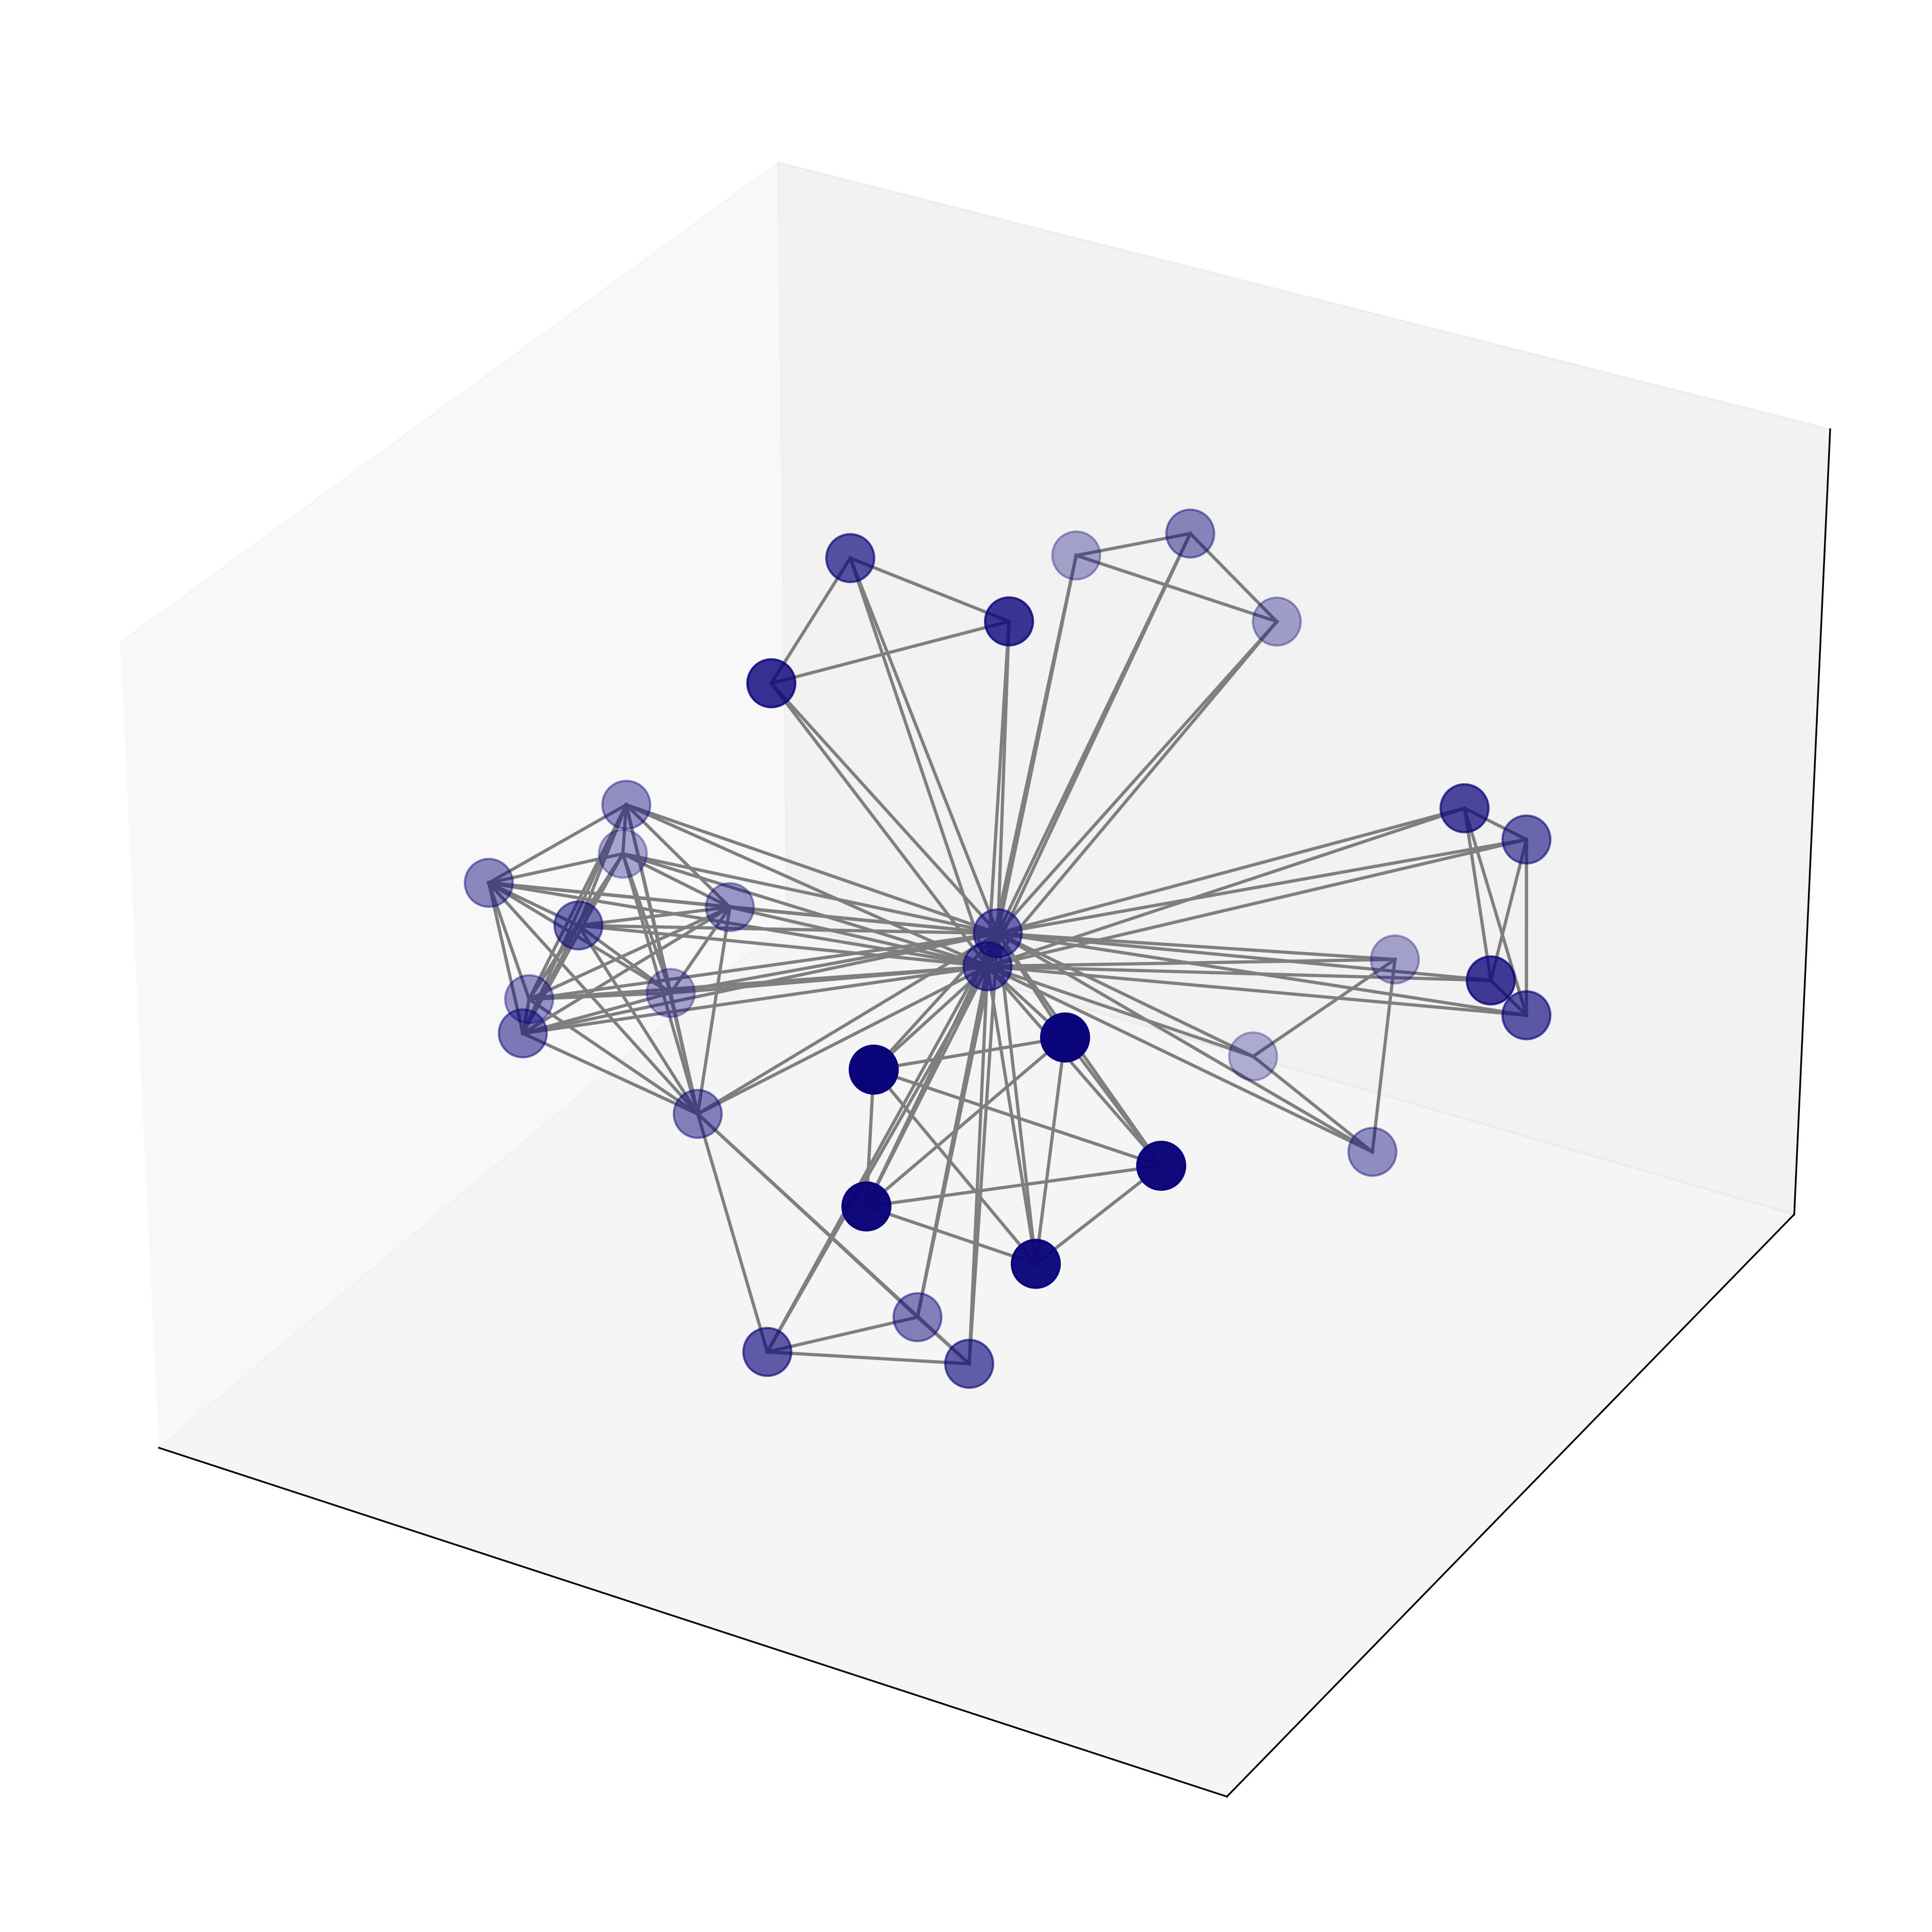

In [13]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[1], to_undirected=True)
pos = nx.spring_layout(G, dim=3, seed=0)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

ax.scatter(*node_xyz.T, s=500, c="#0A047A")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

plt.show()

#Util.py

In [14]:
from typing import List, Tuple
from torch_geometric.data import Data

def stat_graph(graphs_list: List[Data]):
    num_total_nodes = []
    num_total_edges = []
    for graph in graphs_list:
        num_total_nodes.append(graph.num_nodes)
        num_total_edges.append(  graph.edge_index.shape[1] )
    avg_num_nodes = sum( num_total_nodes ) / len(graphs_list)
    avg_num_edges = sum( num_total_edges ) / len(graphs_list) / 2.0
    avg_density = avg_num_edges / (avg_num_nodes * avg_num_nodes)

    median_num_nodes = np.median( num_total_nodes )
    median_num_edges = np.median(num_total_edges)
    median_density = median_num_edges / (median_num_nodes * median_num_nodes)

    return avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density

#Graphon_estimator.py

#Model.py

In [15]:
from torch_geometric.nn import GINConv, global_mean_pool, JumpingKnowledge
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from math import ceil
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, JumpingKnowledge
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, DenseGraphConv, dense_mincut_pool, dense_diff_pool
from torch_geometric.utils import to_dense_batch, to_dense_adj


class GIN(torch.nn.Module):
    def __init__(self, num_features=1, num_classes=1, num_hidden=32):
        super(GIN, self).__init__()

        dim = num_hidden

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        # x = global_add_pool(x, batch)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#Gmixup.py

In [16]:
import time

from torch_geometric.utils import degree
from torch.autograd import Variable

import random
from torch.optim.lr_scheduler import StepLR
import argparse


def prepare_dataset_x(dataset):
    print('X--dataset')
    print('before adding x', dataset[0])

    if dataset[0].x is None:
        print('In x is none')
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max( max_degree, degs[-1].max().item() )
            data.num_nodes = int( torch.max(data.edge_index) ) + 1

        if max_degree < 2000:
            # dataset.transform = T.OneHotDegree(max_degree)
            #print('In x is none ---if')
            for data in dataset:
                #print(data.edge_index)
                #print(data.edge_index[0])
                #degs = degree(data.edge_index[0], dtype=torch.long)
                #print('edge_index of o',data.edge_index[0])

                degs = torch.zeros(data.num_nodes, dtype=torch.long)
                for edge in data.edge_index[0]:
                    degs[edge.item()] += 1
                # print('degs',degs)
                # print('len of degs', len(degs))
                # print('max_degree', max_degree)
                data.x = F.one_hot(degs, num_classes=max_degree+1).to(torch.float)
                #print('X got generated after one hot')
                #break
        else:
            print('In x is none ---else')
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = ( (degs - mean) / std ).view( -1, 1 )

    # print('X added', data.x)
    # print('len of all x', len(data.x))
    # print('x o', data.x[0])
    # print('shape of x o', data.x[0].shape)
    # print('len of x o', len(data.x[0]))

    #input()
    return dataset


def prepare_dataset_onehot_y(dataset):

    y_set = set()
    for data in dataset:
        y_set.add(int(data.y))
    num_classes = len(y_set)

    for data in dataset:
        data.y = F.one_hot(data.y, num_classes=num_classes).to(torch.float)[0]
    return dataset


def mixup_cross_entropy_loss(input, target, size_average=True):
    """Origin: https://github.com/moskomule/mixup.pytorch
    in PyTorch's cross entropy, targets are expected to be labels
    so to predict probabilities this loss is needed
    suppose q is the target and p is the input
    loss(p, q) = -\sum_i q_i \log p_i
    """
    assert input.size() == target.size()
    assert isinstance(input, Variable) and isinstance(target, Variable)
    loss = - torch.sum(input * target)
    return loss / input.size()[0] if size_average else loss




def train(model, train_loader):
    model.train()
    loss_all = 0
    graph_all = 0
    for data in train_loader:
        #print('T1',data)
        #print('T2',data.edge_index)
        data = data.to(device)
        optimizer.zero_grad()
        #print('T3')
        output = model(data.x, data.edge_index, data.batch)
        #print('T4')
        y = data.y.view(-1, num_classes)
        loss = mixup_cross_entropy_loss(output, y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        graph_all += data.num_graphs
        optimizer.step()
    loss = loss_all / graph_all
    return model, loss


def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, num_classes)
        loss += mixup_cross_entropy_loss(output, y).item() * data.num_graphs
        y = y.max(dim=1)[1]
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    loss = loss / total
    return acc, loss

#Adding Edges

In [17]:
import networkx as nx
import torch_geometric
import itertools
from itertools import combinations
from networkx import Graph

#inp=[[[1,2], [2,3],[2,4],[1,4]]]

# Converting PyTorch Geometric graphs to NetworkX graphs
networkx_graphs = [to_networkx(data, to_undirected=True) for data in dataset[:500]]
#networkx_graphs = [nx.Graph(data) for data in inp]
new_augmented_graphs = [to_networkx(data, to_undirected=True) for data in dataset[:500]]

# Function to find biconnected components and cut vertices
def find_biconnected_components_and_cut_vertices(graph):
    biconnected_components = list(nx.biconnected_components(graph)) #gives us nodes in each biconnected component
    cut_vertices = list(nx.articulation_points(graph))
    return biconnected_components, cut_vertices

biconnected_components_list = [] #List with nodes in each biconnected component
biconnected_components_with_edges = []  #List with edges in each biconnected component
cut_vertices_list = []


# Find biconnected components for each graph
for graph in networkx_graphs:
    components, cut_vertices = find_biconnected_components_and_cut_vertices(graph)
    edges_components = list(nx.biconnected_component_edges(graph))
    biconnected_components_list.append(components) #list contaiing sets of nodes in each biconnceted component of a particular graph
    cut_vertices_list.append(cut_vertices) #List conatining Lists of cut vertices in a particular graph
    biconnected_components_with_edges.append(edges_components)#List containg of lists of edges in each biconnected component of a particular graph
#print("Biconnected Components List:", biconnected_components_list[0])
#print("\nCut Vertices List:", cut_vertices_list[0])
#print("Biconnected components with edges",biconnected_components_with_edges[0])

updated_dataset = []
for i in range(len(biconnected_components_list)):#Taking each graph
    for j in range(len(biconnected_components_with_edges[i])): #Taking each biconnected component of that graph

        biset=biconnected_components_list[i][j] # Taking the set of nodes in each biconnected component, biset is the set of nodes in a biconnected component
#        print("The biset is",biset)

        edge_list=biconnected_components_with_edges[i][j] # Taking the list of edges in each biconnected component

#        print("The edge_list is",edge_list)

#        bilist=list(biset)
        bilist=list(itertools.combinations(biset,2)) #Getting a list of all possible edges between the nodes in a biconnected component
#        print("List of edges possible in biconnected component:",bilist)
        for (a,b) in bilist:
                if (a,b) or (b,a) not in edge_list: # Add an edge to the graph if it doesn't already exist
                    new_augmented_graphs[i].add_edge(a,b)


    original_graph = dataset[i]

    # Extract node and edge information from PyTorch Geometric object

    #edge_index = original_graph.edge_index # issue with edge index - because we are increasing edges but still taking edge of old graph
    x = original_graph.x  # Node features
    y = original_graph.y


    # Convert Updated Graph back to PyTorch Geometric Data
    # edges = list(new_augmented_graphs[i].edges())
    # updated_edge_index = torch.tensor(list(map(list, zip(*edges))), dtype=torch.long)


    # #updated_edge_index = torch.tensor(list(new_augmented_graphs[i].edges())).T.contiguous()
    # degs = degree(updated_edge_index[0], dtype=torch.long)
    # print('augmented num_nodes',num_nodes)
    # print('augmented degree',len(degs))

    edges = list(new_augmented_graphs[i].edges())
    #updated_edge_index = torch.tensor(list(map(list, zip(*edges))), dtype=torch.long)
    updated_edge_index = torch.tensor(list(new_augmented_graphs[i].edges())).T.contiguous()

    num_nodes = new_augmented_graphs[i].number_of_nodes()  # Number of nodes in the graph
    updated_data = Data(edge_index=updated_edge_index,  y=y, num_nodes=num_nodes, x=x)
    updated_dataset.append(updated_data)

    # Calculate the degrees using the edge_index tensor
    # degs = torch.zeros(num_nodes, dtype=torch.long)
    # for edge in edge_index[0]:
    #     degs[edge.item()] += 1

    # print('augmented num_nodes', num_nodes)
    # print('augmented degree--new', degs)

    # print('original num_nodes',num_nodes)
    # print('original degree',len(degree(original_graph.edge_index[0], dtype=torch.long)))
    # input()



# G=nx.Graph(new_augmented_graphs[0])
# print(G.edges())
# print(G.nodes())

#print(dataset[80])
#print(updated_dataset[80])
# input()



#Calling Gmixup.py

In [18]:
lam_range = [0.005, 0.01]
gmixup = False
num_epochs = 200

num_hidden = 64
batch_size = 20
learning_rate = 0.0001
ge = "MC"
aug_ratio = 0.15
aug_num = 10
model = "GIN"
device = "cpu"

#dataset = list(dataset)

train_nums_start =  500
val_test_nums = 300

dataset = dataset + updated_dataset
dataset = list(dataset)

#constant_dataset = dataset[0:train_nums_start]
val_dataset = dataset[0:val_test_nums] #constant_dataset[0:val_test_nums]
test_dataset = dataset[val_test_nums:train_nums_start] #constant_dataset[val_test_nums:train_nums_start]
#dataset = dataset[train_nums_start:]

print(f"val_dataset size: {len(val_dataset)}")
print(f"test_dataset size: {len(test_dataset)}" )

for graph in dataset:
    graph.y = graph.y.view(-1)

dataset = prepare_dataset_onehot_y(dataset)

random.shuffle( dataset )

# train_nums = int(len(dataset) * 0.7)
# train_val_nums = int(len(dataset) * 0.8)


# print(dataset[0])
# input()

avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(dataset[train_nums_start:])
print(f"avg num nodes of training graphs: { avg_num_nodes }")
print(f"avg num edges of training graphs: { avg_num_edges }")
print(f"avg density of training graphs: { avg_density }")
print(f"median num nodes of training graphs: { median_num_nodes }")
print(f"median num edges of training graphs: { median_num_edges }")
print(f"median density of training graphs: { median_density }")

resolution = int(median_num_nodes)
# print(dataset[0])
# input()
# if gmixup == True:
#     num_sample = int(train_nums * aug_ratio / aug_num)
#     lam_list = np.random.uniform(low=lam_range[0], high=lam_range[1], size=(aug_num,))

#     updated_dataset = []
#     for i in range(len(dataset)):
#         original_graph = dataset[i]

#         # Extract node and edge information from PyTorch Geometric object
#         num_nodes = original_graph.num_nodes
#         edge_index = original_graph.edge_index
#         x = original_graph.x  # Node features
#         y = original_graph.y
#         # for j in range(len(y)):
#         #   graph_class = graph.y[j].item()
#         #   if graph_class != 0:
#         #     print("Class of the graph:", graph_class)

#         # Create a NetworkX graph
#         nx_graph = nx.Graph()
#         nx_graph.add_nodes_from(range(num_nodes))
#         nx_graph.add_edges_from(edge_index.T.numpy())

#         # Step 1: Find Biconnected Components and Cut Vertices
#         biconnected_components = list(nx.biconnected_components(nx_graph))
#         cut_vertices = list(nx.articulation_points(nx_graph))

#         if cut_vertices:
#           # Step 2: Remove Cut Vertices
#           updated_graph = nx_graph.copy()
#           updated_graph.remove_nodes_from(cut_vertices)
#           #print(list(biconnected_components[0]))


#           updated_graph.add_edge(random.choice(list(biconnected_components[0])), random.choice(list(biconnected_components[1])))

#           # Convert Updated Graph back to PyTorch Geometric Data
#           updated_edge_index = torch.tensor(list(updated_graph.edges())).T.contiguous()
#           updated_data = Data(x=x, edge_index=updated_edge_index, y=y)
#           updated_dataset.append(updated_data)


#     # Append the augmented graphs to the dataset
#     dataset = updated_dataset + dataset
#     train_nums = train_nums + len(updated_dataset)
#     train_val_nums = train_val_nums + len(updated_dataset)


# print(dataset[0])
# input()
dataset = prepare_dataset_x( dataset )

# print(dataset[0])
# input()
print(f"num_features: {dataset[0].x.shape}" )
print(f"num_classes: {dataset[0].y.shape}"  )

num_features = dataset[0].x.shape[1]
num_classes = dataset[0].y.shape[0]

train_dataset = dataset[train_nums_start:]
random.shuffle(train_dataset)

print(f"train_dataset size: {len(train_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


if model == "GIN":
    model = GIN(num_features=num_features, num_classes=num_classes, num_hidden=num_hidden).to(device)
else:
    print(f"No model."  )


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

total_acc = 0

# Create empty numpy arrays to accumulate metrics
val_acc_array = np.zeros(num_epochs - 1)
val_loss_array = np.zeros(num_epochs - 1)
test_acc_array = np.zeros(num_epochs - 1)
test_loss_array = np.zeros(num_epochs - 1)
train_loss_array = np.zeros(num_epochs - 1)


for epoch in range(1, num_epochs):
    model, train_loss = train(model, train_loader)
    train_acc = 0
    val_acc, val_loss = test(model, val_loader)
    test_acc, test_loss = test(model, test_loader)
    total_acc += test_acc
    scheduler.step()

     # Assign metrics for the current epoch to the corresponding array indices
    val_acc_array[epoch - 1] = val_acc
    val_loss_array[epoch - 1] = val_loss
    test_acc_array[epoch - 1] = test_acc
    test_loss_array[epoch - 1] = test_loss
    train_loss_array[epoch -1] = train_loss

    print('Epoch: {:03d}, Train Loss: {:.6f}, Val Loss: {:.6f}, Test Loss: {:.6f},  Val Acc: {: .6f}, Test Acc: {: .6f}'.format(
      epoch, train_loss, val_loss, test_loss, val_acc, test_acc))

print(f'\n Avg Accuracy:     {(total_acc / num_epochs)*100:.2f}%')

val_dataset size: 300
test_dataset size: 200
avg num nodes of training graphs: 19.992
avg num edges of training graphs: 92.0655
avg density of training graphs: 0.2303479915375514
median num nodes of training graphs: 16.0
median num edges of training graphs: 119.0
median density of training graphs: 0.46484375
X--dataset
before adding x Data(edge_index=[2, 380], y=[2], num_nodes=20)
In x is none
num_features: torch.Size([20, 136])
num_classes: torch.Size([2])
train_dataset size: 1000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 001, Train Loss: 0.647874, Val Loss: 0.560376, Test Loss: 0.561331,  Val Acc:  0.860000, Test Acc:  0.870000
Epoch: 002, Train Loss: 0.614655, Val Loss: 0.519367, Test Loss: 0.532233,  Val Acc:  0.903333, Test Acc:  0.915000
Epoch: 003, Train Loss: 0.588599, Val Loss: 0.476096, Test Loss: 0.498315,  Val Acc:  0.966667, Test Acc:  0.960000
Epoch: 004, Train Loss: 0.555742, Val Loss: 0.440231, Test Loss: 0.462827,  Val Acc:  0.943333, Test Acc:  0.915000
Epoch: 005, Train Loss: 0.528710, Val Loss: 0.413689, Test Loss: 0.427446,  Val Acc:  0.933333, Test Acc:  0.900000
Epoch: 006, Train Loss: 0.508645, Val Loss: 0.420846, Test Loss: 0.437371,  Val Acc:  0.876667, Test Acc:  0.865000
Epoch: 007, Train Loss: 0.484623, Val Loss: 0.463814, Test Loss: 0.447331,  Val Acc:  0.806667, Test Acc:  0.840000
Epoch: 008, Train Loss: 0.468465, Val Loss: 0.441741, Test Loss: 0.437196,  Val Acc:  0.786667, Test Acc:  0.825000
Epoch: 009, Train Loss: 0.451351, Val Loss: 0.460677, Test Loss: 0.44127

#Graphs for Test and Validation Loss & Accurecy

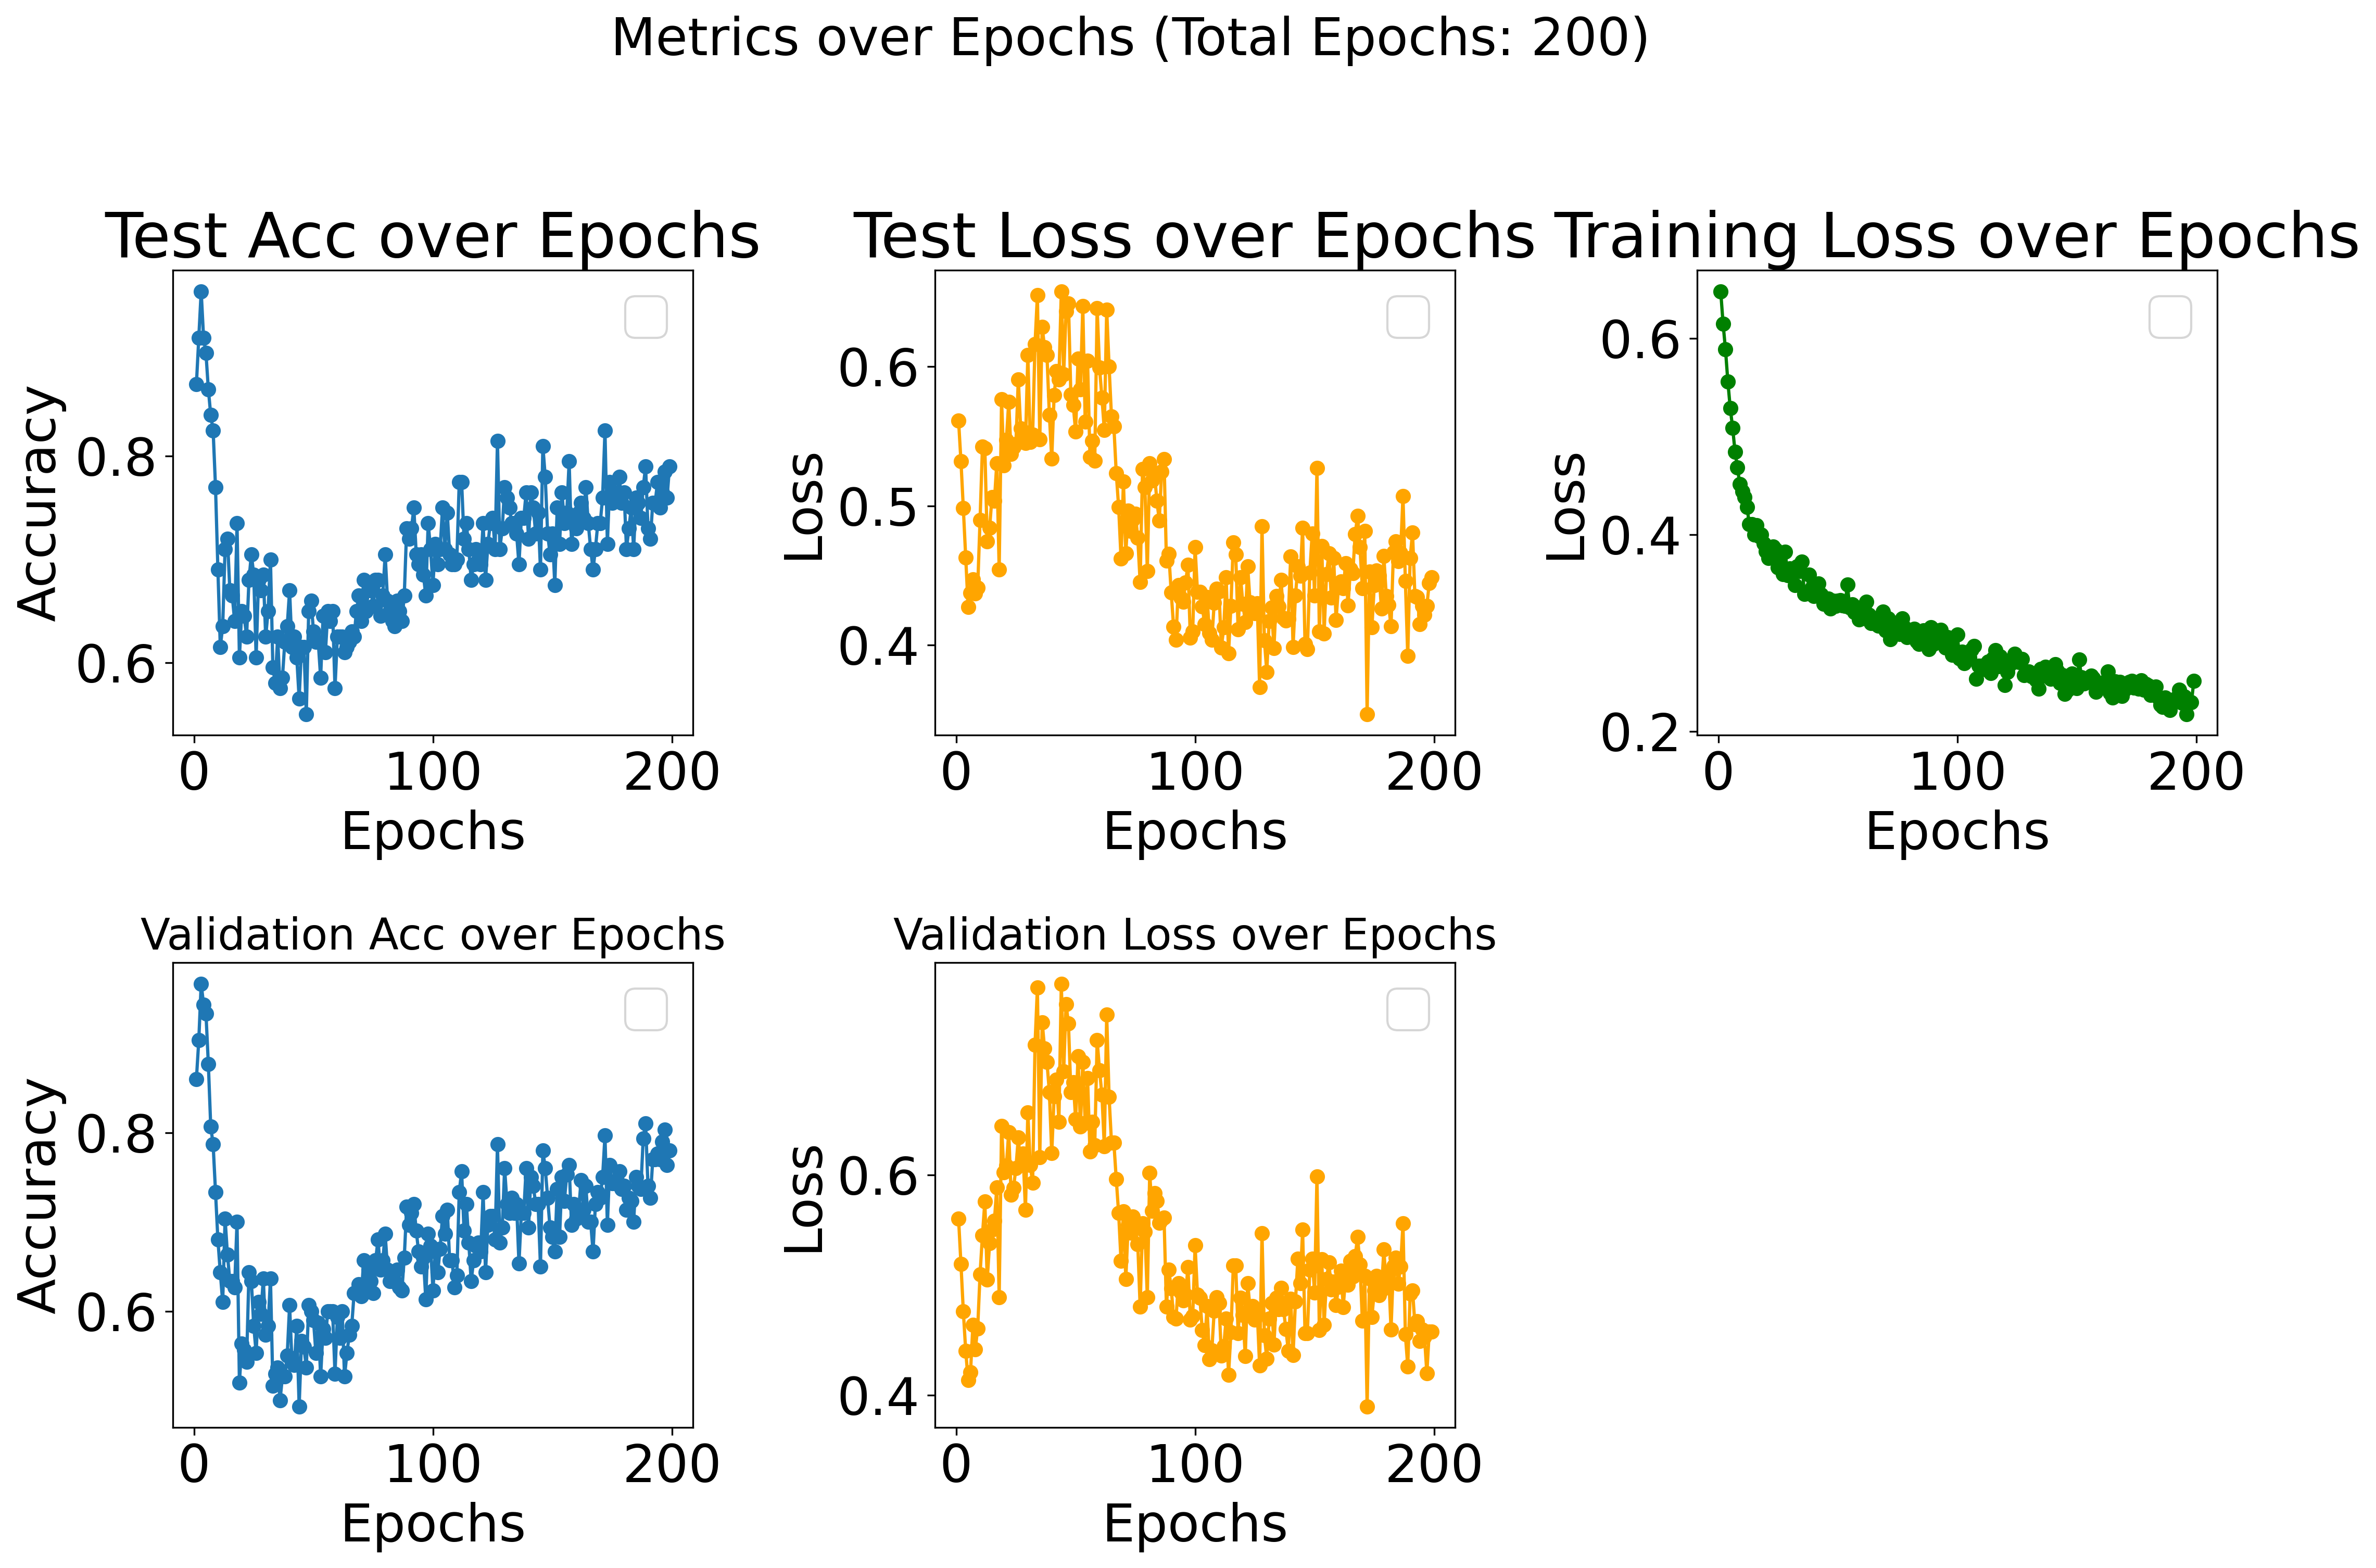

In [19]:
import matplotlib.pyplot as plt2
epochs = np.arange(1, num_epochs)
plt2.figure(figsize=(15, 10))

# Plotting Test Accuracy and Loss
plt2.subplot(2, 3, 1)
plt2.plot(epochs, test_acc_array, marker='o')
plt2.title('Test Acc over Epochs')
plt2.xlabel('Epochs')
plt2.ylabel('Accuracy')
plt2.legend()

plt2.subplot(2, 3, 2)
plt2.plot(epochs, test_loss_array, marker='o', color='orange')
plt2.title('Test Loss over Epochs')
plt2.xlabel('Epochs')
plt2.ylabel('Loss')
plt2.legend()

#plotting training loss
plt2.subplot(2, 3, 3)
plt2.plot(epochs, train_loss_array, marker='o', color='green')
plt2.title('Training Loss over Epochs')
plt2.xlabel('Epochs')
plt2.ylabel('Loss')
plt2.legend()

# Plotting Validation Accuracy and Loss
plt2.subplot(2, 3, 4)
plt2.plot(epochs, val_acc_array, marker='o')
plt2.title('Validation Acc over Epochs', fontsize=20)
plt2.xlabel('Epochs')
plt2.ylabel('Accuracy')
plt2.legend()

plt2.subplot(2, 3, 5)
plt2.plot(epochs, val_loss_array, marker='o', color='orange')
plt2.title('Validation Loss over Epochs', fontsize=20)
plt2.xlabel('Epochs')
plt2.ylabel('Loss')
plt2.legend()

plt2.tight_layout(rect=[0, 0, 1, 0.96])  # Increase the value in the last parameter if needed

plt2.suptitle('Metrics over Epochs (Total Epochs: {})'.format(num_epochs), y=1.02, fontsize=24)

plt2.tight_layout()
plt2.show()

# Rolling Mean Graphs

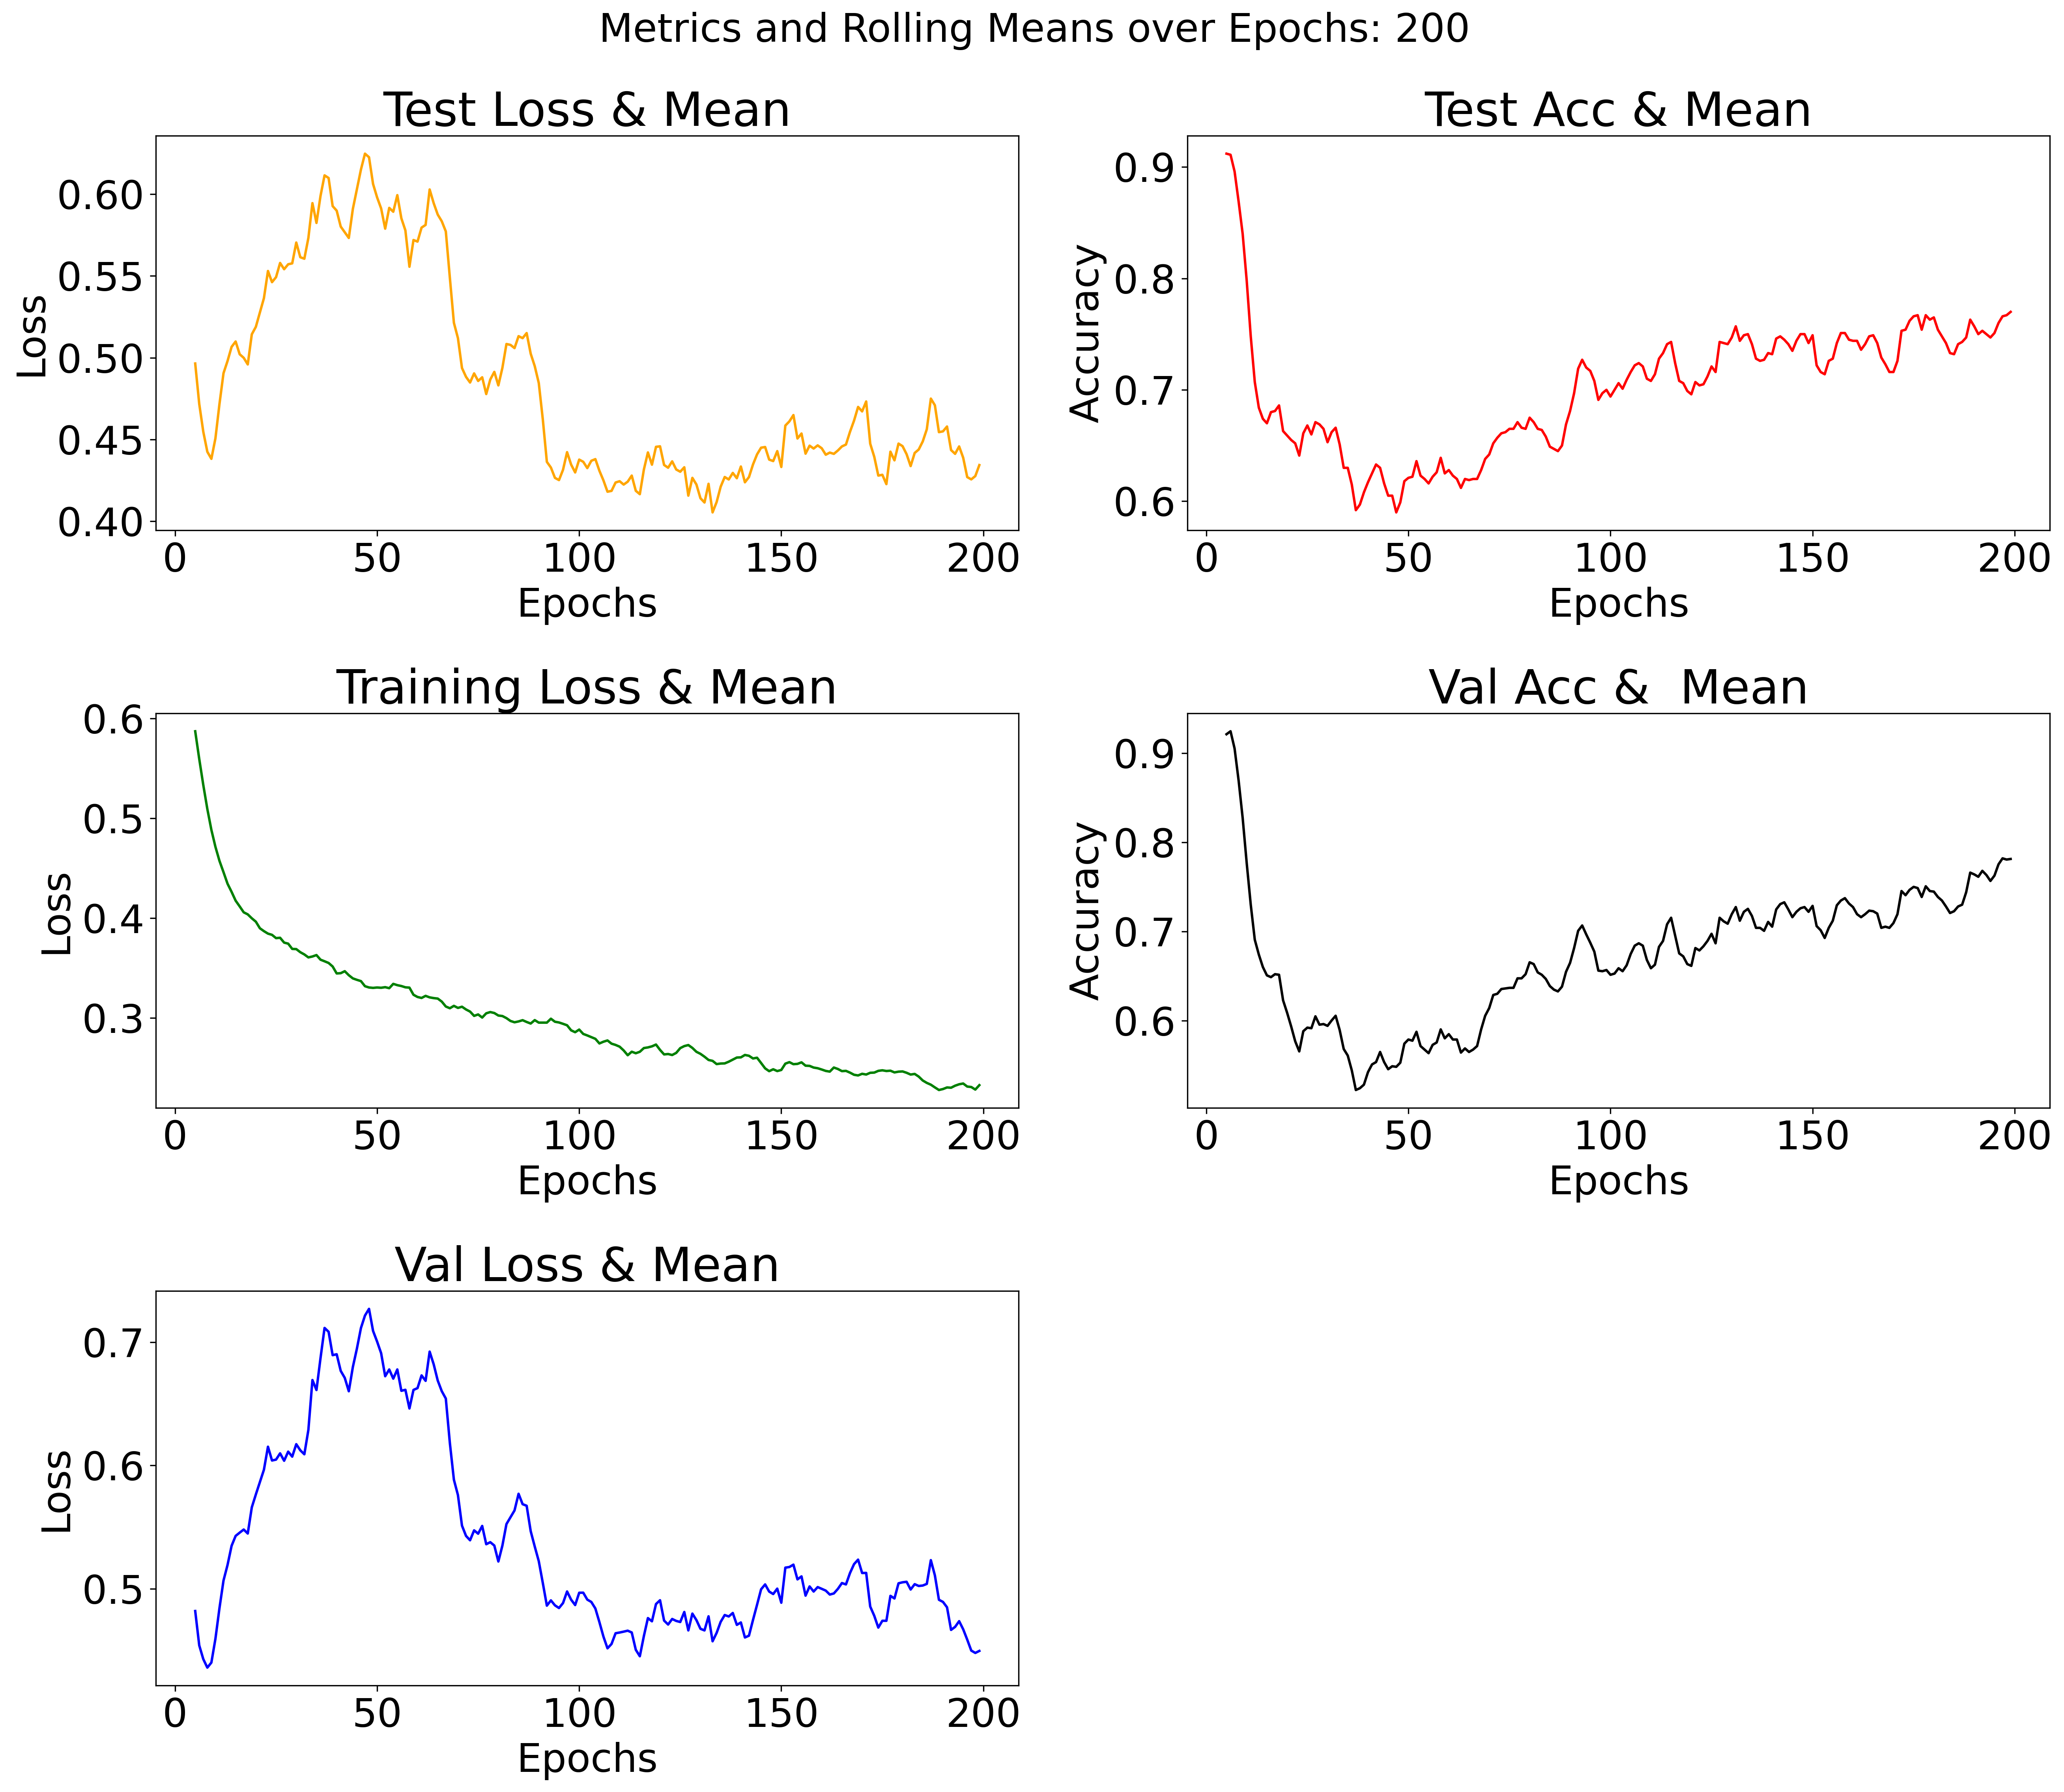

In [20]:
import matplotlib.pyplot as plt3
import pandas as pd

epochs = np.arange(1, num_epochs)
# Creating rolling means for each array
val_loss_rolling_mean = pd.Series(val_loss_array, index=epochs).rolling(5).mean()
val_acc_rolling_mean = pd.Series(val_acc_array, index=epochs).rolling(5).mean()
test_loss_rolling_mean = pd.Series(test_loss_array, index=epochs).rolling(5).mean()
test_acc_rolling_mean = pd.Series(test_acc_array, index=epochs).rolling(5).mean()
train_loss_rolling_mean = pd.Series(train_loss_array, index=epochs).rolling(5).mean()

# Creating subplots for each metric and its rolling mean
plt3.figure(figsize=(18, 15))



# Subplot 1 - Test Loss and its Rolling Mean
plt3.subplot(3, 2, 1)
plt3.plot(epochs, test_loss_rolling_mean, marker='', linestyle='-', color='orange')
plt3.title('Test Loss & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Loss')

# Subplot 2 - Test Accuracy and its Rolling Mean
plt3.subplot(3, 2, 2)
plt3.plot(epochs, test_acc_rolling_mean, marker='', linestyle='-', color='red')
plt3.title('Test Acc & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Accuracy')


# Subplot 3 - Training Loss and its Rolling Mean
plt3.subplot(3, 2, 3)
plt3.plot(epochs, train_loss_rolling_mean, marker='', linestyle='-', color='green')
plt3.title('Training Loss & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Loss')


# Subplot 2 - Validation Accuracy and its Rolling Mean
plt3.subplot(3, 2, 4)
plt3.plot(epochs, val_acc_rolling_mean, marker='', linestyle='-', color='black')
plt3.title('Val Acc &  Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Accuracy')


# Subplot 5 - Validation Loss and its Rolling Mean
plt3.subplot(3, 2, 5)
plt3.plot(epochs, val_loss_rolling_mean, marker='', linestyle='-', color='blue')
plt3.title('Val Loss & Mean')
plt3.xlabel('Epochs')
plt3.ylabel('Loss')


# Adjust layout to prevent overlap
plt3.tight_layout()

# Adding a single title at the top
plt3.suptitle('Metrics and Rolling Means over Epochs: {}'.format(num_epochs), y=1.02, fontsize=24)

plt3.show()
